In [1]:
import numpy as np
import matplotlib.pyplot as plt
import epidemic_model_classes_numba as epi_mod
from data_loading import LoadData 
from proj_consts import ProjectConsts
import pandas as pd
from PIL import Image
import time
import os

log_paths = [[], [], [], [], []]
for log in os.listdir("../logs/sdumont"):
    if "South Korea" in log:
        log_paths[int(log.split("posts_")[1][:2])//10-1].append("../logs/sdumont/" + log + "/")

log_paths = np.array(log_paths, dtype=object)
        
log_labels = ["10", "20", "30", "40", "50"]

# data_path = open("data_path.txt", "r").read()
# df_brazil_state_cases = pd.read_csv(data_path)

# pop_state_dat = open(f"{ProjectConsts.DATA_PATH}/pop_states.csv", "r").read().split("\n")
# pop_state = {}
# for i in range(len(pop_state_dat)-1):
#     pop_state_dat[i] = pop_state_dat[i].split(", ")
#     pop_state[pop_state_dat[i][0]] = int(pop_state_dat[i][1])

In [2]:
log_paths = log_paths[:,0]

In [3]:
locations = open(r"skIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD2"]
print(locations)
print(models)

['South Korea']
['SEIRD2']


In [4]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

3


In [5]:
location = locations[0]

days_sets = sorted(os.listdir(log_paths[-1]+"Posterior1/%s/%s/"%(location, models[0])), key=lambda x: int(x.split("_")[0]))[:-3]
n_days = len(days_sets)

days = []

for days_set in days_sets:
    
    days.append(int(days_set.split("_")[0]))

days = np.array(days)

In [6]:
days

array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110,
       115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175,
       180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240,
       245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305,
       310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370,
       375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425])

In [7]:
day_step = np.diff(days)[0]

In [8]:
rmsd_train = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_val= [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_total = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]

trials = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
post_size = np.zeros((len(models), len(log_paths), n_days))

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(log_paths)):
        
        params.append(np.zeros((n_days, model.nparams)))
        
        path = log_paths[i]+"Posterior%i/%s/%s/" % (1, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):

            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]

            for line in range(len(log_file)):

                if "Training window size:" in log_file[line]:
                    post_size[model_idx, i, days_idx] = int(log_file[line].split(" ")[-1])
        
        path = log_paths[i]+"Posterior%i/%s/%s/" % (n_post, location, models[model_idx])

        for days_idx in range(len(days_sets)):

            params[-1][days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")

            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]

            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line

                if ("Number of trials" in log_file[line]):

                    trials[i][model_idx, days_idx] = int(log_file[line].split(" ")[-1])

            rmsd_train[i][model_idx, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[i][model_idx, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[i][model_idx, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

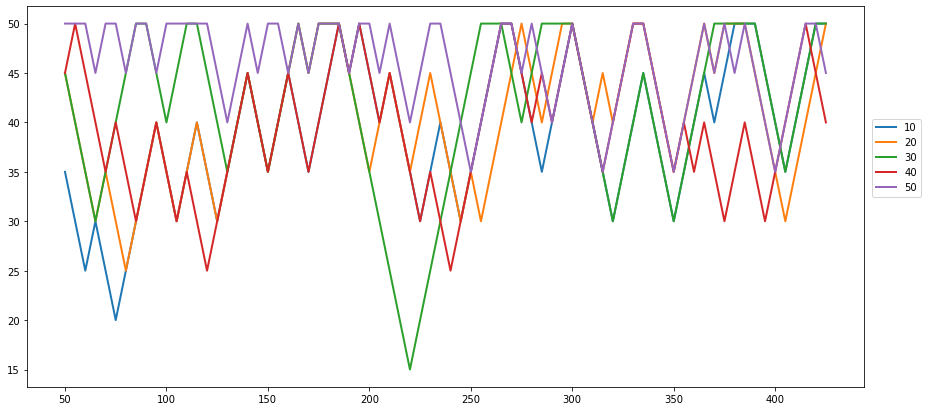

In [9]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    plt.plot(days, post_size[0,i], lw=2, label=str((i+1)*10))
plt.legend(loc=(1.01, 0.5))

In [10]:
plt.rcParams.update({'font.size': 22})

def best_rows_cols(n):
    
    rows = 1
    cols = 1
    
    while (rows*cols < n):
        
        if (rows == cols):
            
            cols += 1
            
        else:
            
            rows += 1
            
    return np.array([rows, cols])

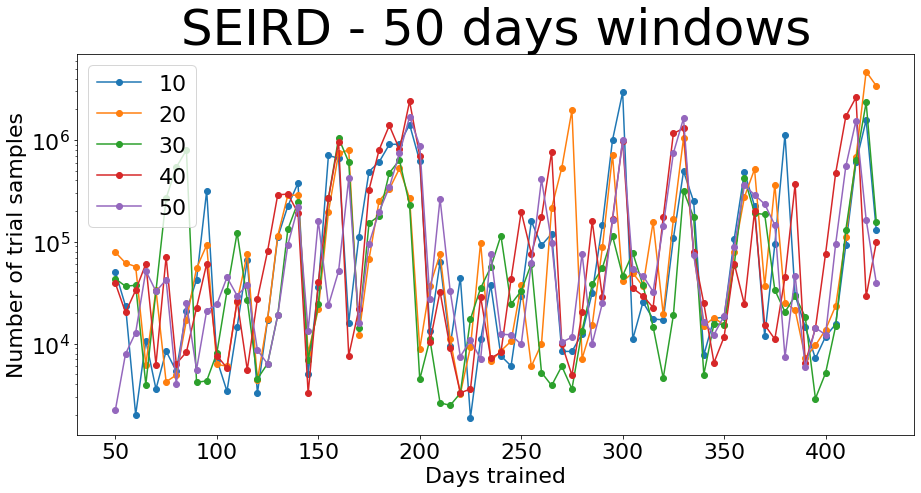

In [11]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,7))
        
    for j in range(len(trials)):
            
        plt.plot(days, trials[j][model_idx], "-o", label=log_labels[j])
        plt.legend()
        plt.xlabel("Days trained")
        plt.ylabel("Number of trial samples")
        plt.yscale("log")
        plt.title(model.plot_name+" - 50 days windows", fontsize=50)
            
    plt.show()

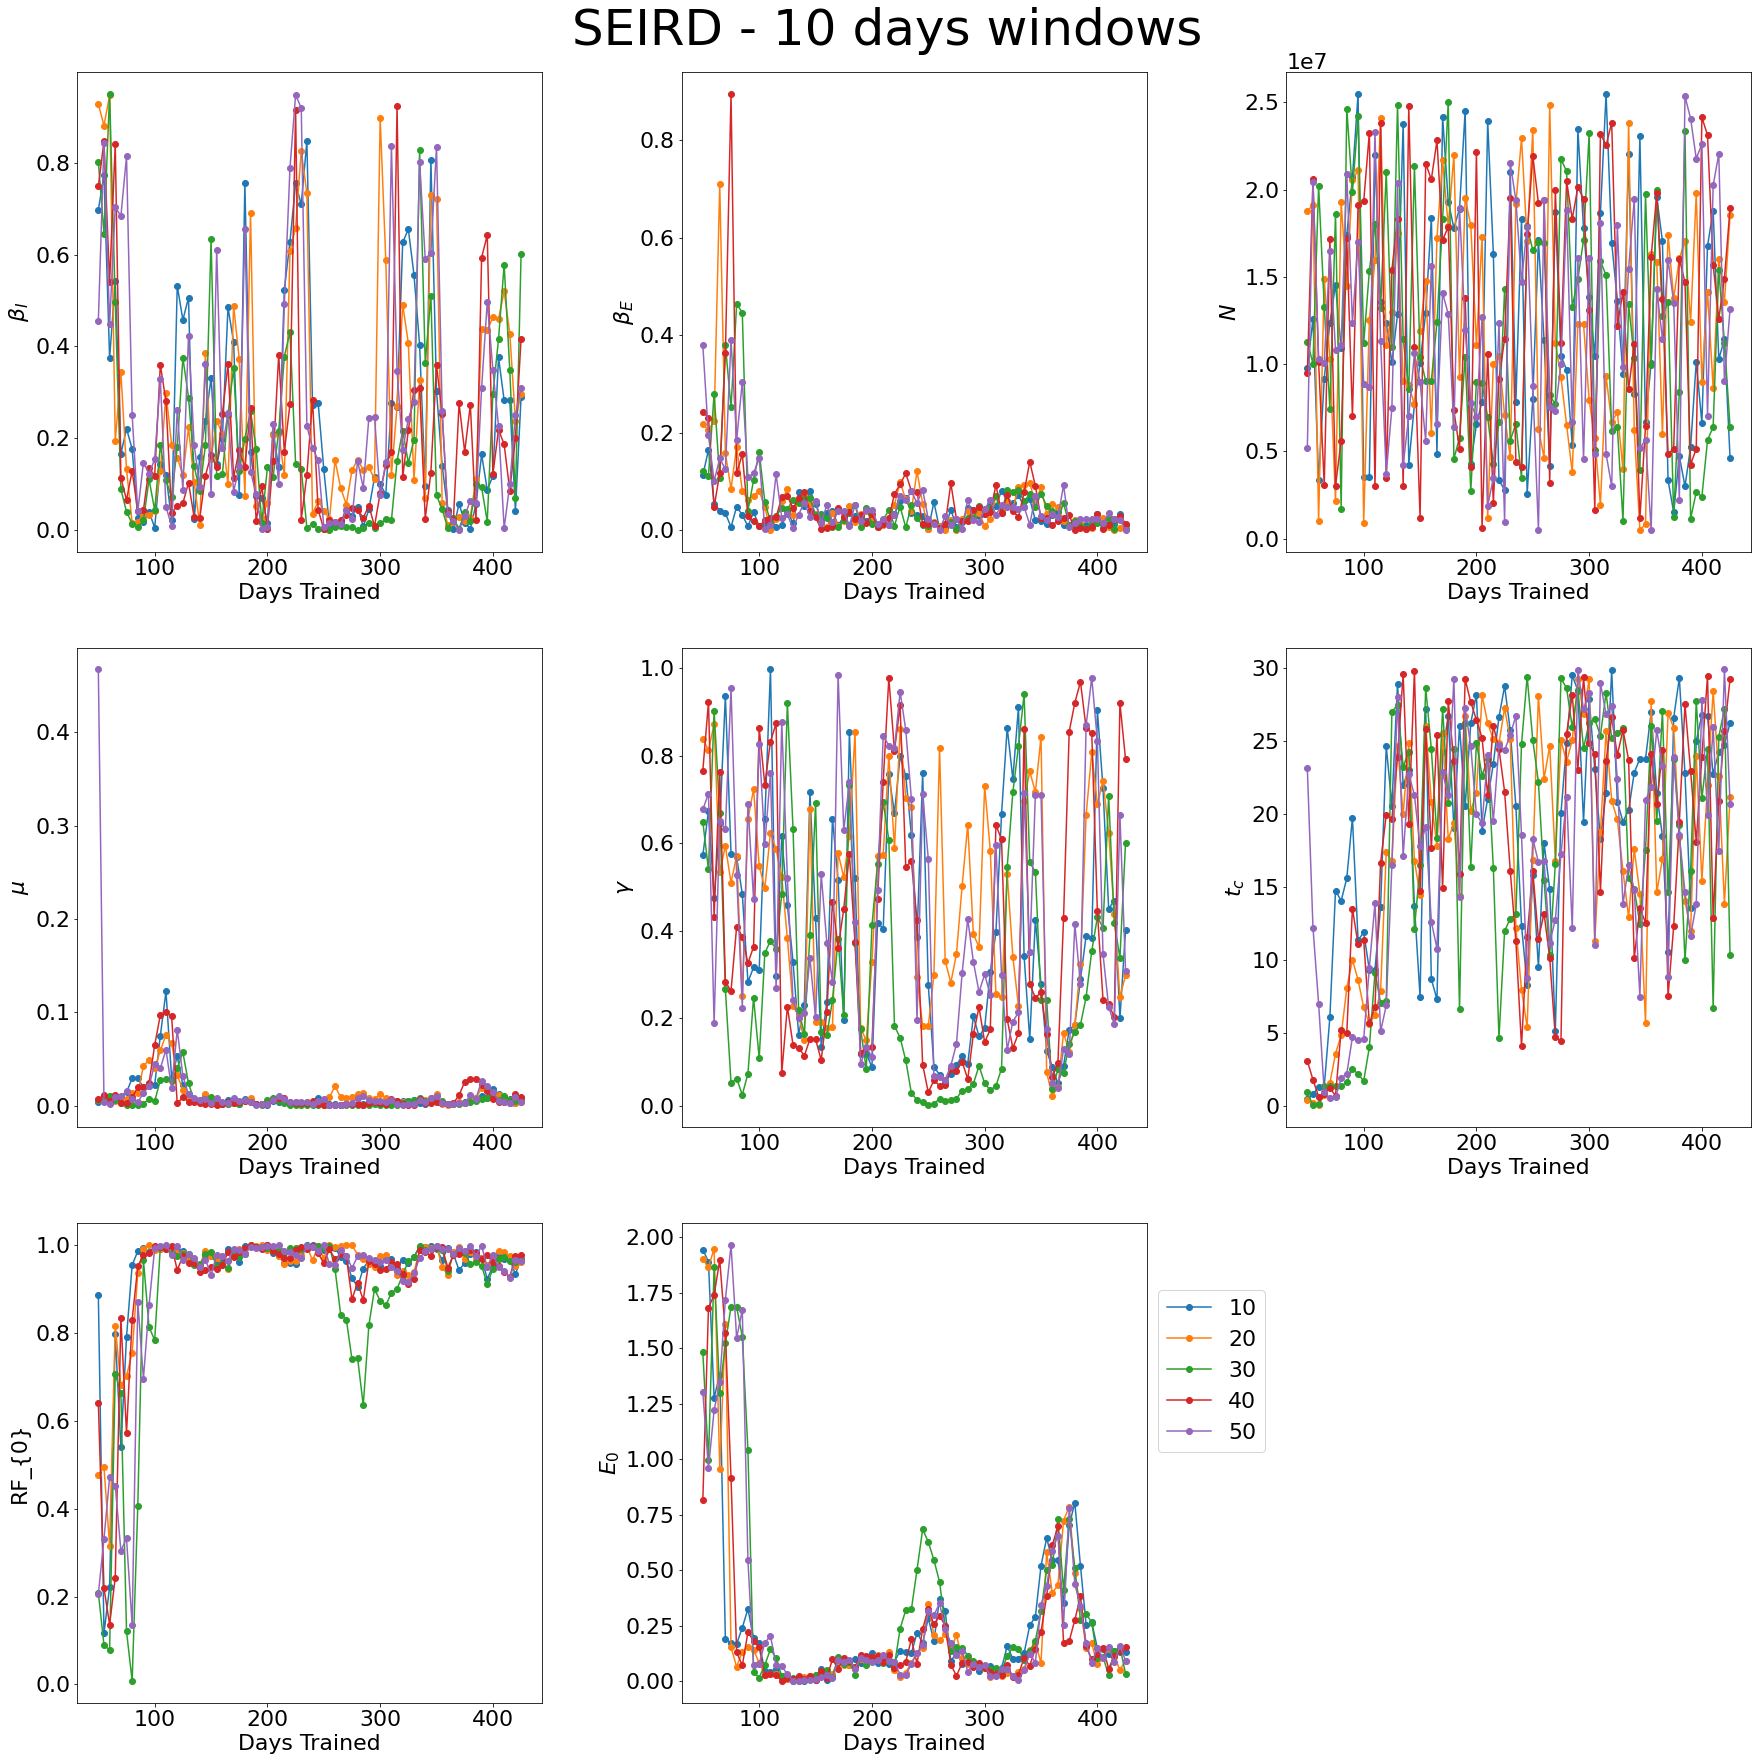

In [12]:
for j in range(len(models)):
    
    model = getattr(epi_mod, models[j])
    
    plt.figure(figsize=(10*best_rows_cols(params[0].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)

    for i in range(params[0].shape[-1]):

        plt.subplot(*best_rows_cols(params[0].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
#         for j in range(params[p].shape[0]):
        for p in range(len(params)):
            plt.plot(days, params[p][:,i], "-o", label=log_labels[p])
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):

            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")

    plt.suptitle(model.plot_name+" - 10 days windows", fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

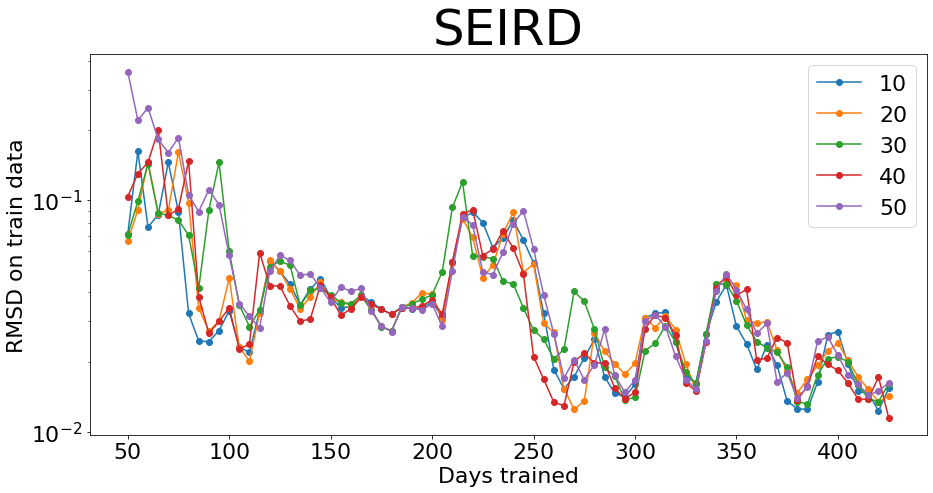

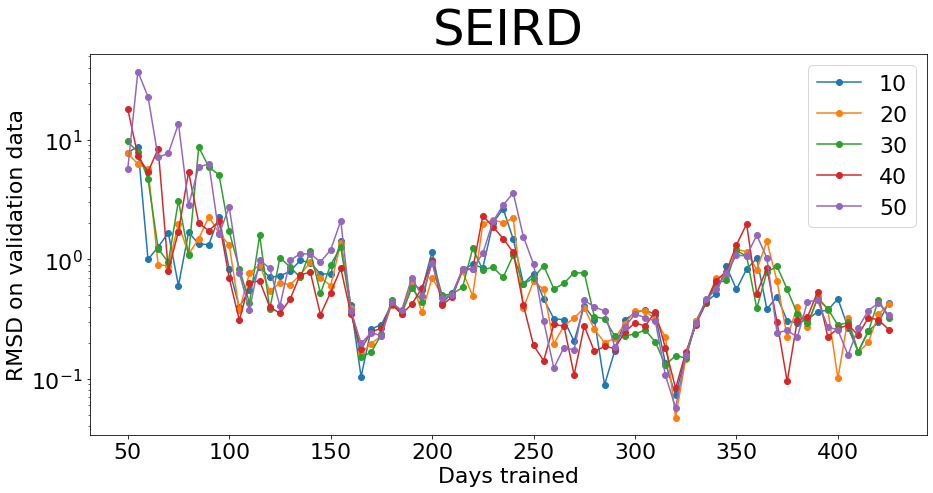

In [13]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)-1):
        
        plt.figure(figsize=(15,7))
        
        for j in range(len(rmsd[i])):
            
            plt.plot(days, rmsd[i][j][model_idx], "-o", label=log_labels[j])
            plt.legend(loc="upper right")
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.yscale("log")
            plt.title(model.plot_name, fontsize=50)
            
    plt.show()

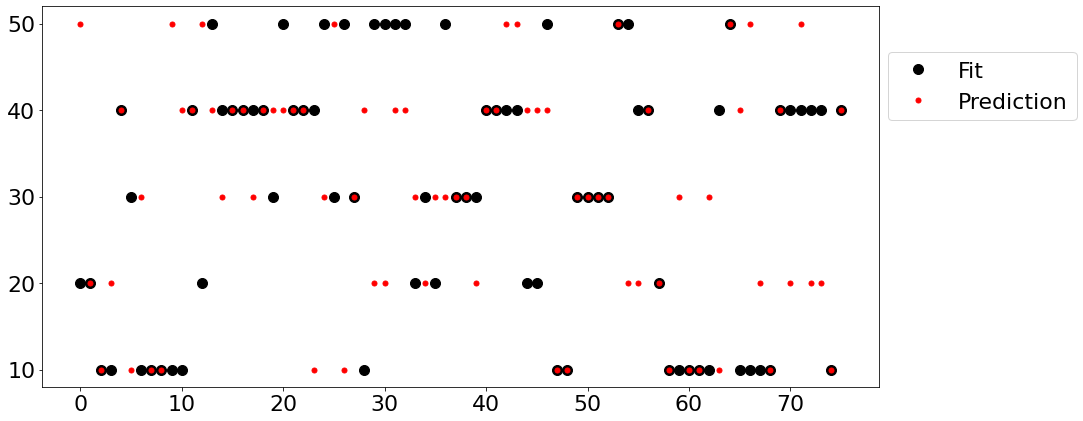

[20, 8, 12, 23, 13]
[14, 13, 16, 23, 10]


In [14]:
rmsd_train_ = np.concatenate(rmsd_train)
rmsd_train_min = np.zeros(rmsd_train_.shape[1])
for i in range(len(rmsd_train_min)):
    rmsd_train_min[i] = (np.where(rmsd_train_[:,i] == np.min(rmsd_train_[:,i]))[0][0]+1)*10

rmsd_val_ = np.concatenate(rmsd_val)
rmsd_val_min = np.zeros(rmsd_val_.shape[1])
for i in range(len(rmsd_val_min)):
    rmsd_val_min[i] = (np.where(rmsd_val_[:,i] == np.min(rmsd_val_[:,i]))[0][0]+1)*10

plt.figure(figsize=(15, 7))
plt.plot(rmsd_train_min, "o", c="k", ms=10, alpha=1, label="Fit")
plt.plot(rmsd_val_min, "o", c="r", ms=5, alpha=1, label="Prediction")
plt.legend(loc=(1.01, 0.7))
plt.show()

train_count = [np.sum(rmsd_train_min==i) for i in [10, 20, 30, 40, 50]]
print(train_count)
val_count = [np.sum(rmsd_val_min==i) for i in [10, 20, 30, 40, 50]]
print(val_count)

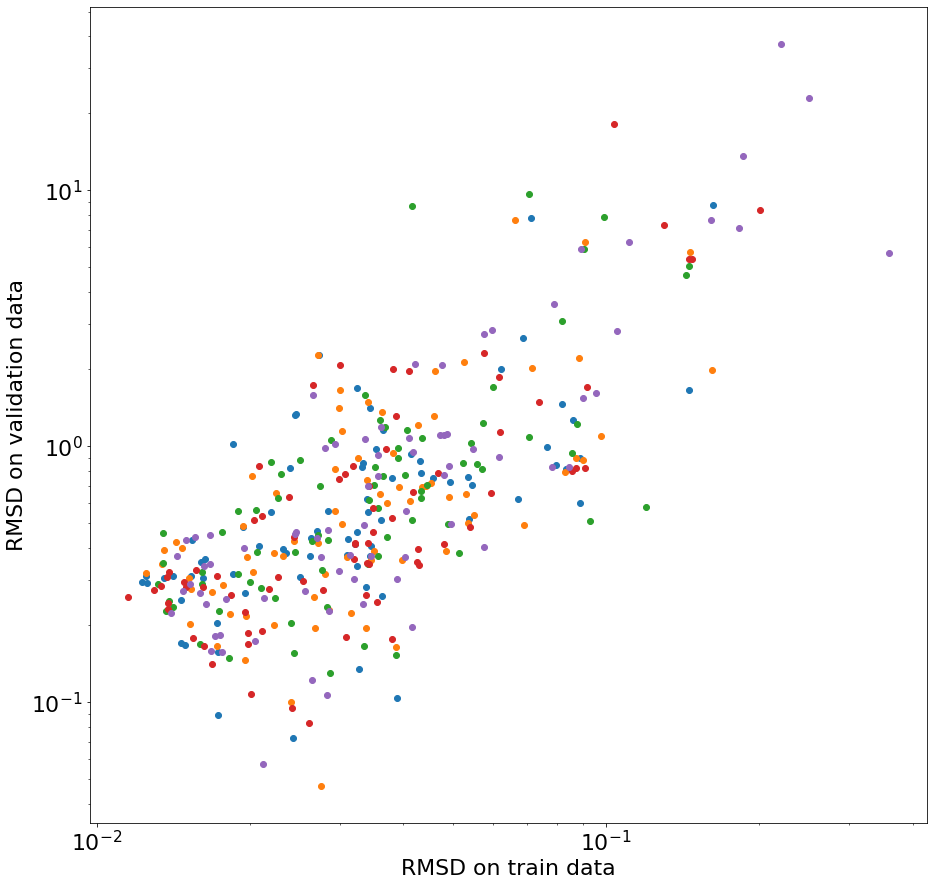

In [15]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,15))
    
    xx = np.linspace(min(np.min(rmsd[0]), np.min(rmsd[1])), min(np.min(rmsd[0]), np.min(rmsd[1])), 2)
    
    for j in range(len(rmsd[0])):
        
        plt.plot(rmsd[0][j].flatten(), rmsd[1][j].flatten(), "o", label="Posterior %i"%(j+1))
#         plt.legend()
        plt.xlabel(rmsd_names[0])
        plt.ylabel(rmsd_names[1])
        plt.xscale("log")
        plt.yscale("log")
#         plt.title(model.plot_name, fontsize=50)
    plt.show()

In [16]:
from scipy.stats import pearsonr

for j in range(len(log_paths)):
    print("--- ", log_labels[j], " ---")
    print("RMSD on train and validation Pearson Correlations:")
    print("Posterior %i:"%(n_post), pearsonr(rmsd[0][j].flatten(), rmsd[1][j].flatten()))
    print()

---  10  ---
RMSD on train and validation Pearson Correlations:
Posterior 3: (0.6063168936240154, 6.456588254701264e-09)

---  20  ---
RMSD on train and validation Pearson Correlations:
Posterior 3: (0.5700522138898976, 7.65553842801431e-08)

---  30  ---
RMSD on train and validation Pearson Correlations:
Posterior 3: (0.5526699300626934, 2.2614989523294016e-07)

---  40  ---
RMSD on train and validation Pearson Correlations:
Posterior 3: (0.6777021680313124, 1.7713308156819007e-11)

---  50  ---
RMSD on train and validation Pearson Correlations:
Posterior 3: (0.7129392817627385, 5.02249734056652e-13)



In [17]:
model = getattr(epi_mod, models[0])
model

epidemic_model_classes_numba.SEIRD2

In [18]:
data = np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[0]+"/data.txt")

for i in range(1, len(days_sets)):
    data = np.concatenate((data, np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[i]+"/data.txt")[-day_step:]))

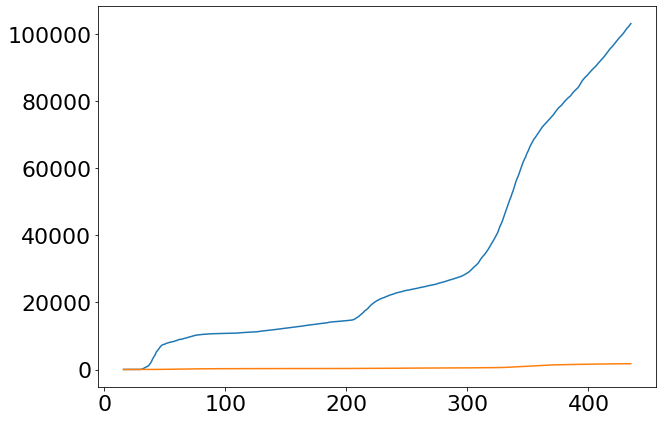

In [19]:
plt.figure(figsize=(10,7))
plt.plot(*data[:,[0,1]].T)
plt.plot(*data[:,[0,2]].T)

In [20]:
train_set_size = int(open(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[0]+f"/{model.name}_log.out", "r").read().split("Training window size: ")[1].split("\n")[0])
train_set_size
t0 = np.copy(train_set_size)

In [21]:
t = np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[0]+"/data.txt")[:,0]
params = np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[0]+"/best_params.txt")
y0 = np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[0]+"/y0.txt")

pred = model.infected_dead(t, params, y0)[:,train_set_size:-day_step].T
pred_t = t[train_set_size:-day_step]

for i in range(1, len(days_sets)):
    train_set_size = int(open(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[i]+f"/{model.name}_log.out", "r").read().split("Training window size: ")[1].split("\n")[0])
    
    t = np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[i]+"/data.txt")[:,0]
    params = np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[i]+"/best_params.txt")
    y0 = np.loadtxt(log_paths[0]+"Posterior1/"+location+"/"+models[0]+"/"+days_sets[i]+"/y0.txt")
    
    pred = np.concatenate((pred, model.infected_dead(t, params, y0)[:,train_set_size:-day_step].T))
    pred_t = np.concatenate((pred_t, t[train_set_size:-day_step]))

In [22]:
pred_t

array([ 51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
       128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 159., 160.,
       161., 162., 163., 164., 165., 166., 167., 168., 169., 170., 171.,
       172., 173., 174., 175., 176., 177., 178., 179., 180., 181., 182.,
       183., 184., 185., 186., 187., 188., 189., 190., 191., 192., 193.,
       194., 195., 196., 197., 198., 199., 200., 20

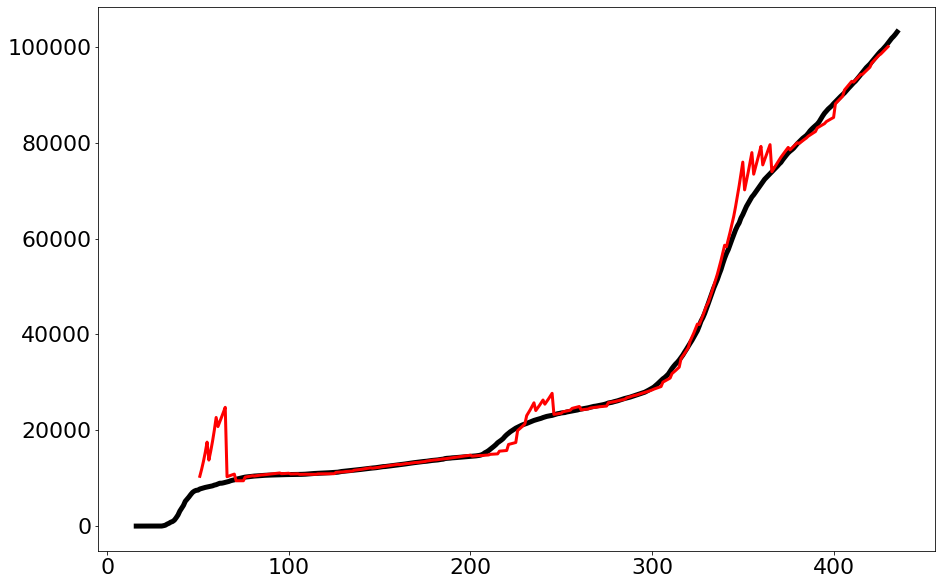

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(data[:,0], data[:,1], lw=5, c="k")
plt.plot(pred_t, pred[:,0], lw=3, c="r")

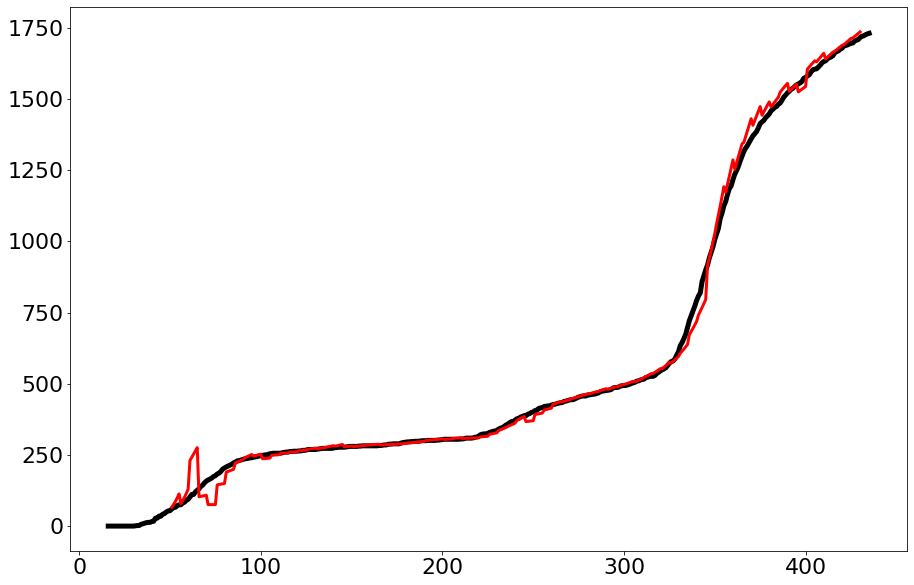

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(data[:,0], data[:,2], lw=5, c="k")
plt.plot(pred_t, pred[:,1], lw=3, c="r")